In [1]:
import gc
import os
import pickle
import jsonlines
import torch
from tqdm import tqdm
import pandas as pd
import csv
from collections import defaultdict
import argparse
from core.models.entailment import EntailmentDeberta
from rank_eval import load_data, load_rank_results


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

# 排序rank_results
def sort_rank_results(rank_results):
    sorted_rank_results = {}
    for qid, results in rank_results.items():
        # 排序
        rank_list = sorted(results.items(), key=lambda x: -x[1])
        rank_list = [x[0] for x in rank_list]
        sorted_rank_results[qid] = rank_list
    return sorted_rank_results

# 排序正确答案
def get_gold_doc_ids(gold_scores):
    gold_doc_ids = {}
    for qid, results in gold_scores.items():
        gold_doc_ids[qid] = set([it[0] for it in results.items() if it[1] > 0])
    return gold_doc_ids

# 获取rank_results中首次正确的位置分布
def get_first_correct_position(rank_results, gold_doc_ids):
    first_correct_position = []
    for qid, results in rank_results.items():
        if qid not in gold_doc_ids:
            continue
        gold_ids = gold_doc_ids[qid]
        for i, doc_id in enumerate(results):
            if doc_id in gold_ids:
                first_correct_position.append(i)
                break
    return first_correct_position

# 画图展示位置分布
def plot_position_distribution(positions, title):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.histplot(positions, bins=100, kde=True)
    plt.xlabel('Position')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

  0%|          | 0/171332 [00:00<?, ?it/s]

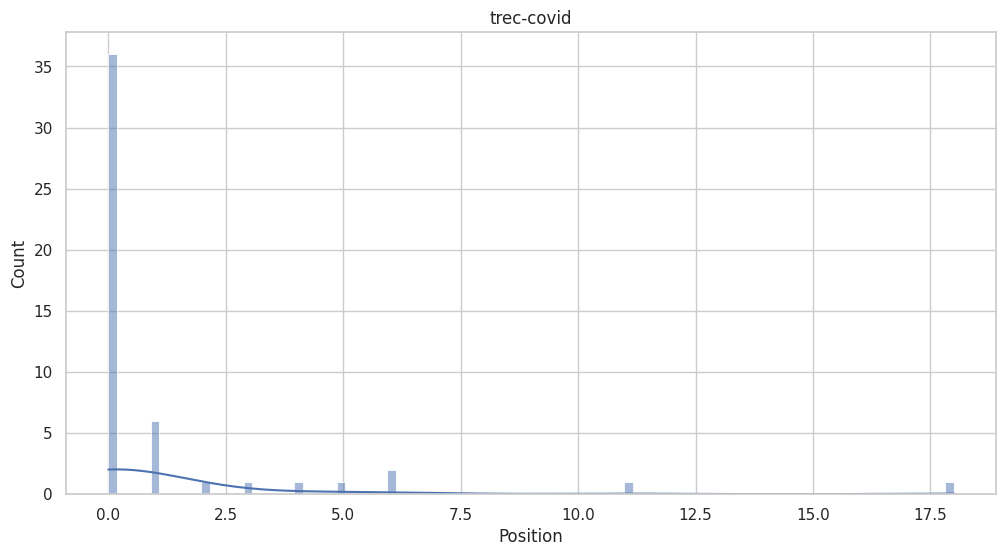

  0%|          | 0/5416593 [00:00<?, ?it/s]

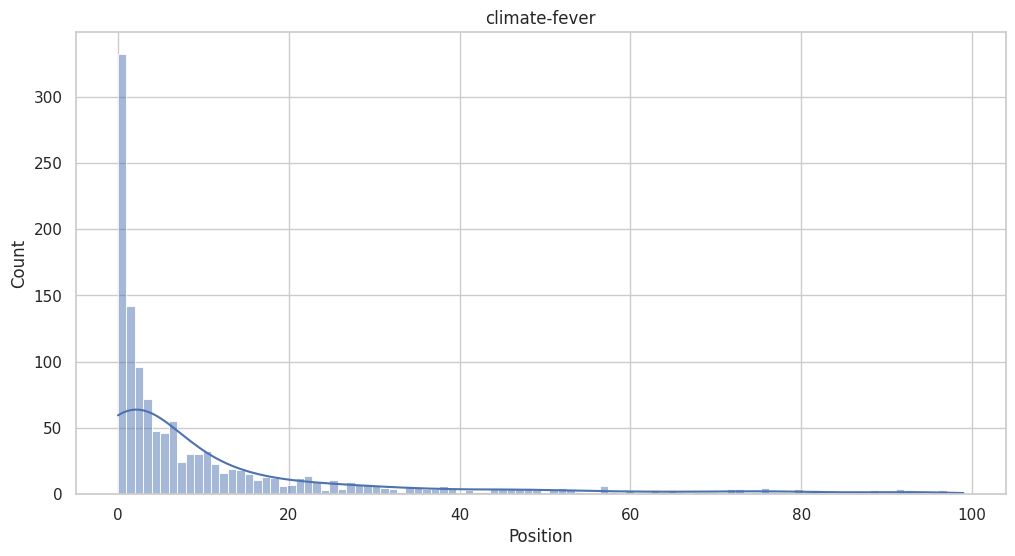

  0%|          | 0/4635922 [00:00<?, ?it/s]

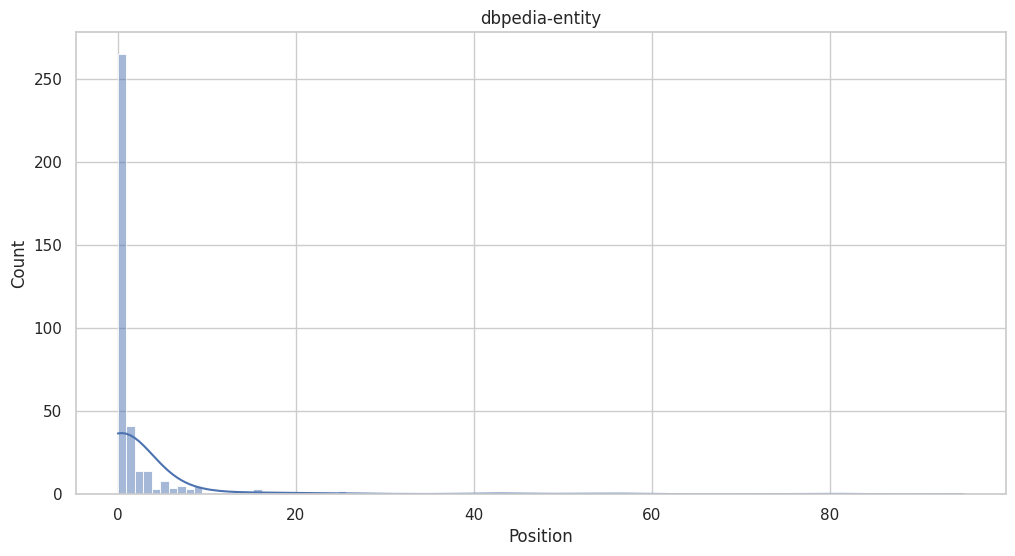

  0%|          | 0/5416568 [00:00<?, ?it/s]

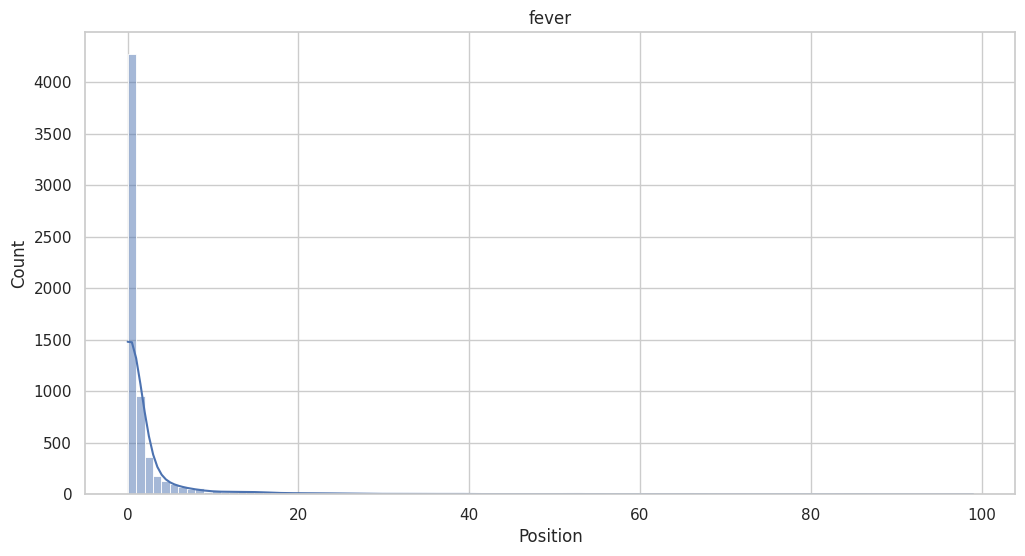

  0%|          | 0/5233329 [00:00<?, ?it/s]

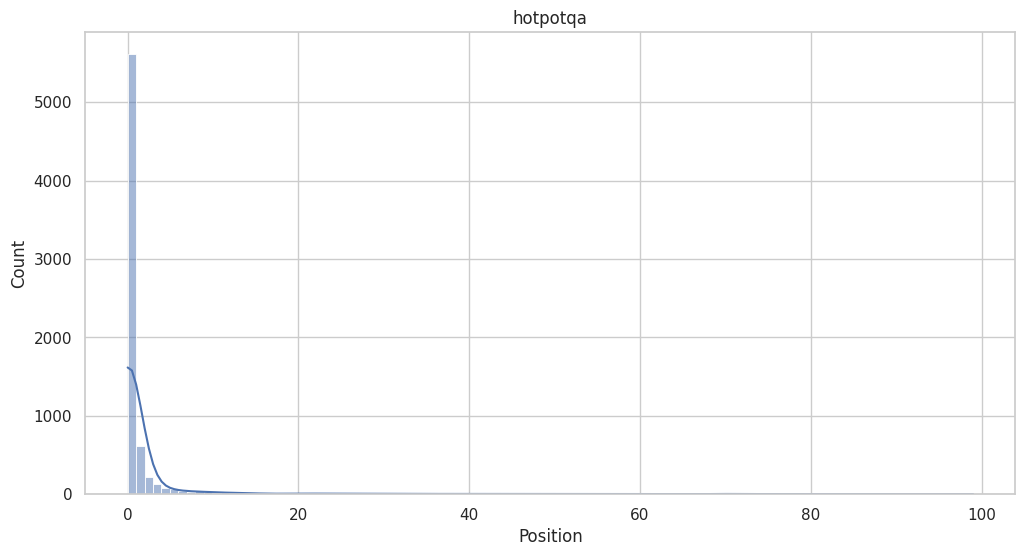

  0%|          | 0/3633 [00:00<?, ?it/s]

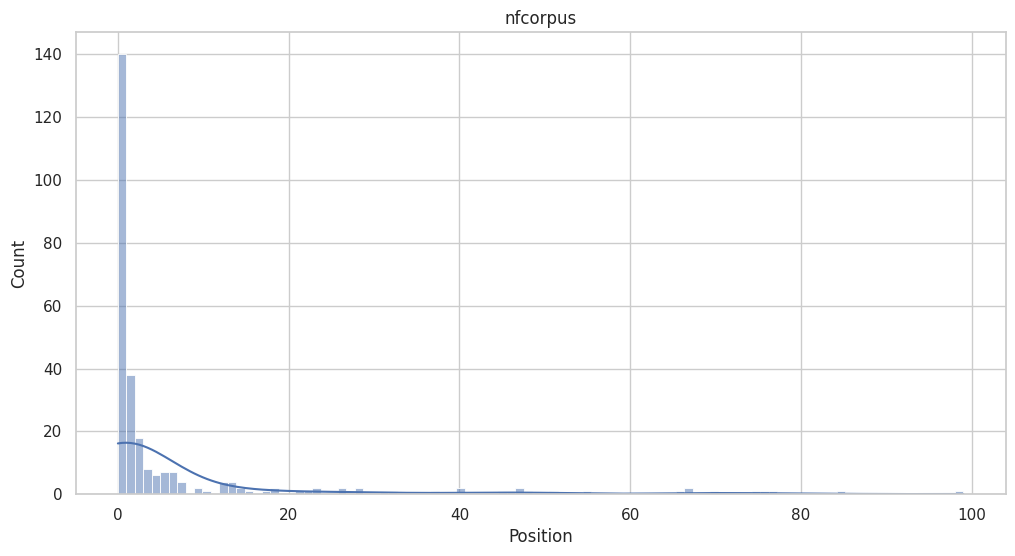

  0%|          | 0/2681468 [00:00<?, ?it/s]

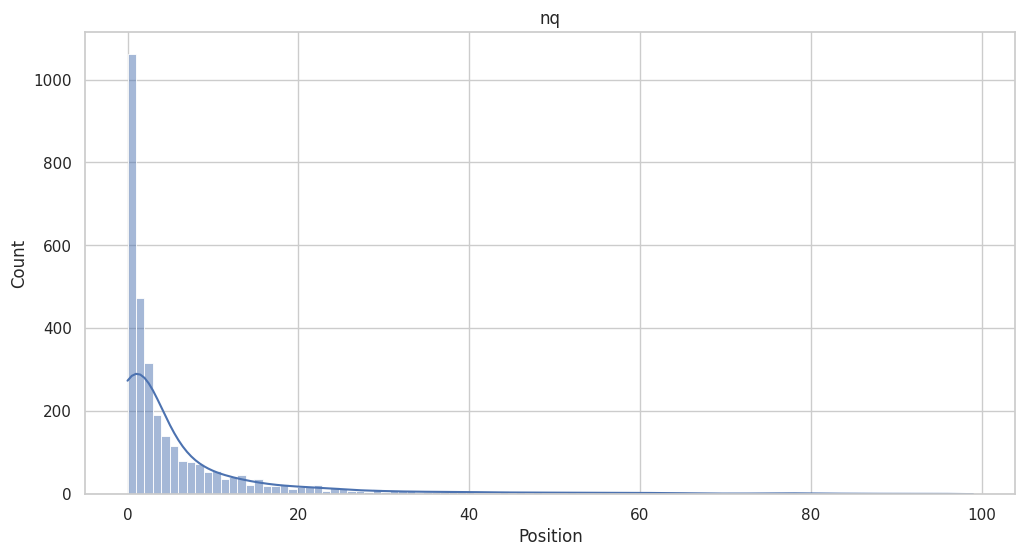

  0%|          | 0/25657 [00:00<?, ?it/s]

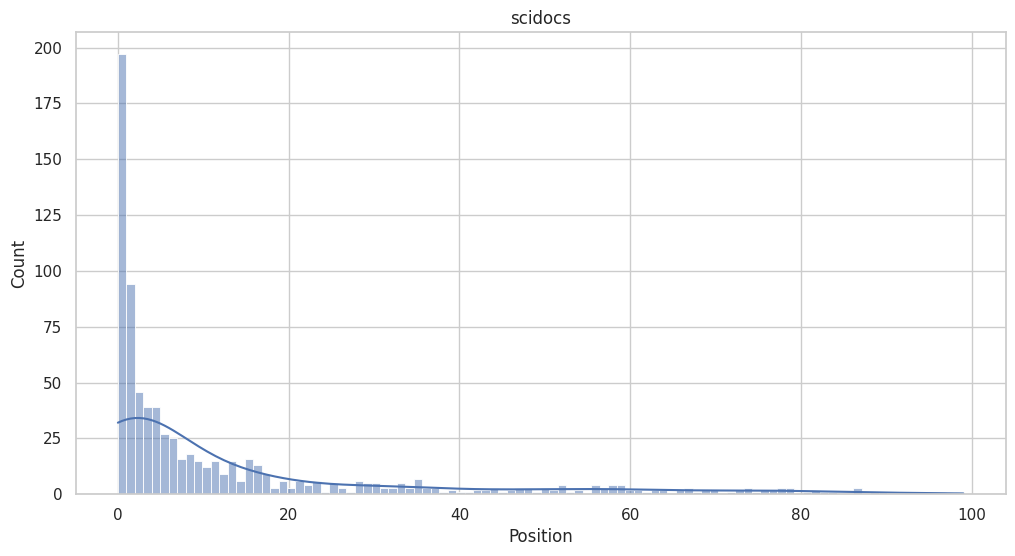

In [2]:
dataset_names = ["trec-covid", "climate-fever", "dbpedia-entity", "fever", "hotpotqa", "nfcorpus", "nq", "scidocs"]
for dataset_name in dataset_names:
    dataset_path = f'/home/song/dataset/beir/{dataset_name}'
    queries, docs, scores = load_data(dataset_path, dataset_name)
    rank_result_path = f'dataset/rank/{dataset_name}/{dataset_name}-rank100.tsv'
    rank_results = load_rank_results(rank_result_path)
    rank_results = sort_rank_results(rank_results)
    gold_doc_ids = get_gold_doc_ids(scores)
    first_correct_position = get_first_correct_position(rank_results, gold_doc_ids)
    plot_position_distribution(first_correct_position, dataset_name)